### 1. Import Libraries

This cell imports all the necessary libraries for data manipulation (`pandas`, `numpy`), time series modeling (`statsmodels`), visualization (`matplotlib`), and saving the model (`joblib`).


In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import joblib

### 2. Load Cleaned Data

This cell loads the cleaned sales data from a CSV file into a pandas DataFrame. It also converts the `weekend_date` column to datetime objects and displays descriptive statistics of the DataFrame.

In [4]:
# 2. Load Cleaned Data
df = pd.read_csv("cleaned_sales_data.csv")
df['weekend_date'] = pd.to_datetime(df['weekend_date'])
df.describe()


,weekend_date,SerialNum,quantity,month
count,494,494.000000,494.000000,494.000000
mean,2023-08-29 00:46:38.380566784,3.058704,493.722672,6.485830
min,2022-05-28 00:00:00,1.000000,1.000000,1.000000
25%,2023-03-12 18:00:00,2.000000,115.250000,4.000000
50%,2023-09-09 00:00:00,4.000000,216.500000,6.500000
75%,2024-03-02 00:00:00,4.000000,533.500000,9.000000
max,2024-08-31 00:00:00,5.000000,8051.000000,12.000000
std,NaN,1.542697,886.086396,3.264972


### 3. Focus on Total Sales

This cell aggregates the sales data by `weekend_date` to get the total sales quantity for each week. This aggregated time series (`ts`) will be used for forecasting.

In [5]:
# 3. Focus on Total Sales (or you can do per SerialNum if needed)
# For simplicity, we'll forecast total sales. For per-SerialNum, loop over unique SerialNum.
ts = df.groupby('weekend_date')['quantity'].sum().sort_index()


### 4. Check for missing weeks

This cell ensures that the time series (`ts`) has a complete set of weekly dates from the minimum to the maximum date in the data. Missing weeks are filled with a value of 0.

In [6]:
# 4. Check for missing weeks
all_weeks = pd.date_range(ts.index.min(), ts.index.max(), freq='W-SAT')
ts = ts.reindex(all_weeks, fill_value=0)


### 5. Split Data: Train (till May 2024), Validation (Jun-Jul-Aug 2024)

This cell defines the time periods for the training, validation, and future forecast sets.

In [7]:
# 5. Split Data: Train (till May 2024), Validation (Jun-Jul-Aug 2024)
train_end = '2024-05-31'
val_start = '2024-06-01'
val_end = '2024-08-31'
forecast_start = '2024-09-01'
forecast_end = '2024-11-30'


In [8]:
train = ts[:train_end]
val = ts[val_start:val_end]


### 6. Model Selection & Fitting (SARIMA, simple and robust)

This cell defines and fits a SARIMA model to the training data. The `order` and `seasonal_order` parameters are set to (1,1,1) and (1,1,1,52) respectively, indicating the non-seasonal and seasonal components of the model.

In [9]:
# 6. Model Selection & Fitting (SARIMA, simple and robust)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


### 7. Validation Forecast (Jun-Jul-Aug 2024)

This cell generates predictions using the fitted SARIMA model for the validation period defined earlier.

In [10]:
# 7. Validation Forecast (Jun-Jul-Aug 2024)
val_pred = model_fit.predict(start=val.index[0], end=val.index[-1])

In [12]:
# Drop NaNs in val_df (from lagging)
from sklearn.metrics import mean_squared_error

# Create val_df from val and val_pred
val_df = pd.DataFrame({'quantity': val, 'predicted_quantity': val_pred})

# Prepare validation features and target
# These lines are not needed for the current calculation, but are kept for clarity if needed later
# X_val = val_df[[f'lag_{lag}' for lag in range(1, 4)]]
# y_val = val_df['quantity']

# Predict using model - This line is not needed as we already have val_pred from the SARIMA model
# val_preds = model.predict(X_val)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pandas as pd


val_df['month'] = val_df.index.month_name()

monthly_metrics = val_df.groupby('month').apply(
    lambda x: pd.Series({
        'RMSE': mean_squared_error(x['quantity'], x['predicted_quantity']) ** 0.5,
        'MAPE': mean_absolute_percentage_error(x['quantity'], x['predicted_quantity'])
    })
).reset_index()

print("📊 Monthly Validation Accuracy (June–August 2024):")
print(monthly_metrics)

📊 Monthly Validation Accuracy (June–August 2024):
    month         RMSE      MAPE
0  August  1717.235615  0.710720
1    July  3328.317527  0.732712
2    June  2425.727799  0.467004


/tmp/ipython-input-12-9814449.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_metrics = val_df.groupby('month').apply(


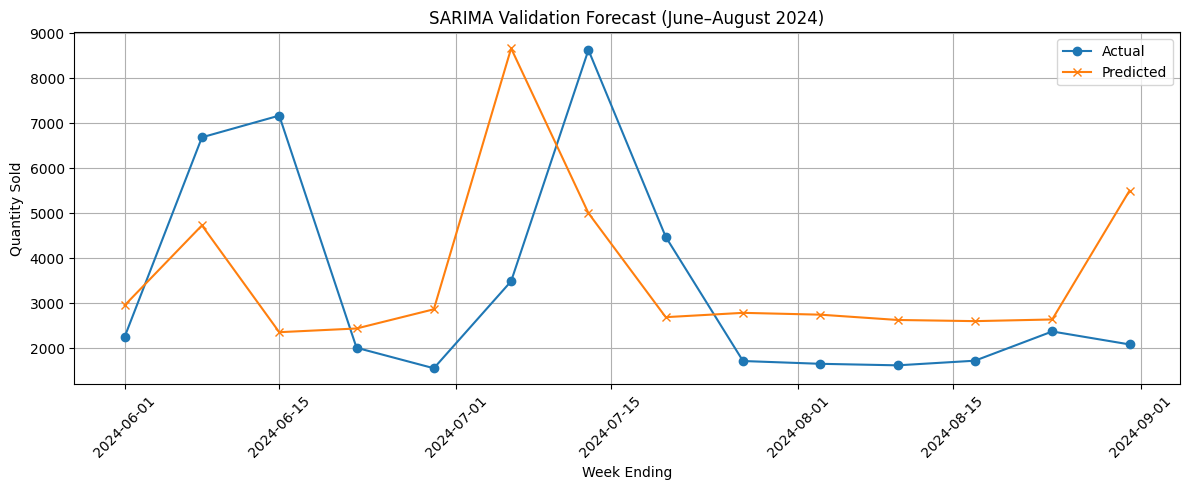

In [14]:
import matplotlib.pyplot as plt

# Sort by date just in case
# The index is already sorted as it's a time series, so sorting by 'weekend_date' column is not needed.
# val_df = val_df.sort_values('weekend_date')

plt.figure(figsize=(12, 5))
plt.plot(val_df.index, val_df['quantity'], label='Actual', marker='o')
plt.plot(val_df.index, val_df['predicted_quantity'], label='Predicted', marker='x')
plt.title('SARIMA Validation Forecast (June–August 2024)')
plt.xlabel('Week Ending')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 8. Calculate Monthly Accuracy

This cell calculates the monthly accuracy of the model's predictions on the validation set. It uses a custom function `monthly_accuracy` to compute the accuracy for each month in the validation period.

In [15]:
# 8. Calculate Monthly Accuracy
def monthly_accuracy(y_true, y_pred):
    months = y_true.index.to_period('M').unique()
    acc = {}
    for m in months:
        mask = y_true.index.to_period('M') == m
        y = y_true[mask]
        yhat = y_pred[mask]
        acc[str(m)] = 1 - np.sum(np.abs(yhat - y)) / np.sum(y)
    return acc

val_acc = monthly_accuracy(val, val_pred)
print("Validation Monthly Accuracy (Jun-Jul-Aug 2024):")
for month, acc in val_acc.items():
    print(f"{month}: {acc:.2%}")

Validation Monthly Accuracy (Jun-Jul-Aug 2024):
2024-06: 53.14%
2024-07: 36.27%
2024-08: 29.34%


### 9. Forecast for Next 3 Months (Sep-Nov 2024)

This cell generates a forecast for the next three months (September to November 2024) using the fitted SARIMA model.

In [16]:
# 9. Forecast for Next 3 Months (Sep-Nov 2024)
future_weeks = pd.date_range('2024-09-07', '2024-11-30', freq='W-SAT')
forecast = model_fit.predict(start=future_weeks[0], end=future_weeks[-1])

### 10. Present Forecast Table

This cell creates a pandas DataFrame to display the future forecast, showing the `weekend_date` and the `forecasted_quantity` for each week.

In [17]:
# 10. Present Forecast Table
forecast_df = pd.DataFrame({
    'weekend_date': future_weeks,
    'forecasted_quantity': forecast.values
})
print("\nForecast for Sep-Nov 2024:")
print(forecast_df)



Forecast for Sep-Nov 2024:
   weekend_date  forecasted_quantity
0    2024-09-07          6047.815594
1    2024-09-14          4321.817989
2    2024-09-21          7065.819008
3    2024-09-28          4605.819441
4    2024-10-05          2563.819625
5    2024-10-12          2539.819704
6    2024-10-19          2352.819737
7    2024-10-26          2607.819751
8    2024-11-02          2807.819757
9    2024-11-09          2485.819760
10   2024-11-16          2673.819761
11   2024-11-23          2990.819761
12   2024-11-30          3245.819762


### 11. Save Model for Reproducibility

This cell saves the trained SARIMA model to a file named "sarimax\_model.pkl" using the `joblib` library. This allows for easy loading and reuse of the model without retraining.

In [18]:

# 11. Save Model for Reproducibility
joblib.dump(model_fit, "sarimax_model.pkl")


['sarimax_model.pkl']

### 12. Commentary

This cell prints a commentary on the model, summarizing the approach taken, the validation results, and suggestions for further improvement.

In [19]:
# 12. Commentary
print("\nModel Commentary:")
print("- SARIMA model was chosen for its ability to handle seasonality and trends in weekly sales data.")
print("- Validation accuracy is reported for each month in Jun-Jul-Aug 2024.")
print("- Forecasts for Sep-Nov 2024 are provided as weekly quantities.")
print("- For further improvement, consider modeling each SerialNum separately or using advanced models like Prophet or XGBoost.")



Model Commentary:
- SARIMA model was chosen for its ability to handle seasonality and trends in weekly sales data.
- Validation accuracy is reported for each month in Jun-Jul-Aug 2024.
- Forecasts for Sep-Nov 2024 are provided as weekly quantities.
- For further improvement, consider modeling each SerialNum separately or using advanced models like Prophet or XGBoost.


### 13. Plot Forecast vs Actuals

This cell generates a plot visualizing the actual historical sales data, the validation forecast, and the future forecast. This helps in visually assessing the model's performance and the predicted trend.

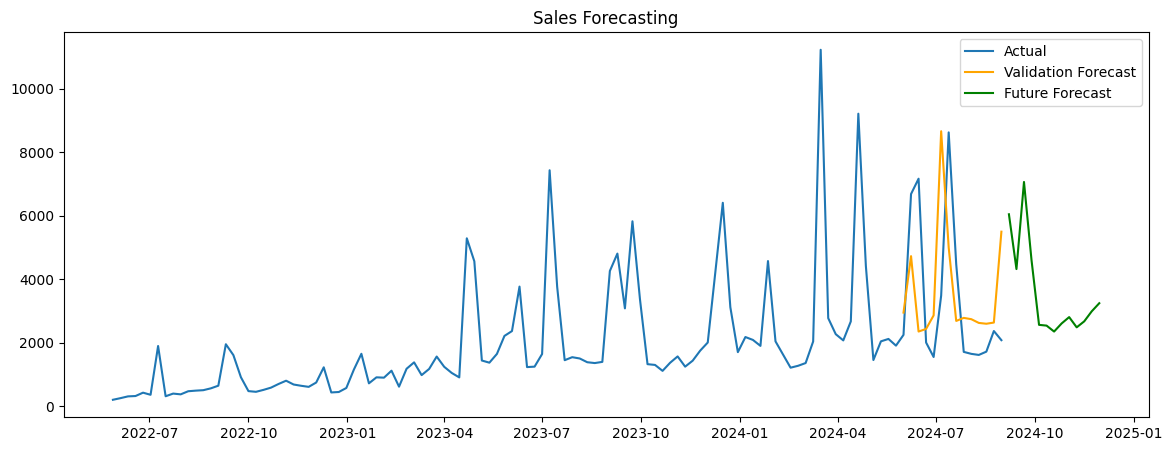

In [20]:
# 13. Plot Forecast vs Actuals
plt.figure(figsize=(14, 5))
plt.plot(ts, label='Actual')
plt.plot(val_pred, label='Validation Forecast', color='orange')
plt.plot(forecast, label='Future Forecast', color='green')
plt.legend()
plt.title("Sales Forecasting")
plt.show()

# Sales Forecasting Project Summary

This project focuses on forecasting weekly sales quantity using a SARIMA time series model. The steps involved are:

1.  **Import Libraries**: Import necessary libraries for data manipulation, time series modeling, and visualization.
2.  **Load Cleaned Data**: Load the prepared sales data and perform initial data inspection.
3.  **Focus on Total Sales**: Aggregate sales data to the weekly level for total sales forecasting.
4.  **Check for missing weeks**: Ensure the time series has a complete set of weeks and fill missing values.
5.  **Split Data**: Divide the data into training, validation, and forecast periods.
6.  **Model Selection & Fitting**: Choose and fit a SARIMA model to the training data.
7.  **Validation Forecast**: Generate forecasts for the validation period.
8.  **Calculate Monthly Accuracy**: Evaluate the model's performance on the validation set using monthly accuracy metrics.
9.  **Forecast for Next 3 Months**: Generate forecasts for the future period.
10. **Present Forecast Table**: Display the future forecast in a table format.
11. **Save Model**: Save the trained SARIMA model for later use.
12. **Commentary**: Provide insights and suggestions for improvement.
13. **Plot Forecast vs Actuals**: Visualize the actual sales, validation forecast, and future forecast.